# Learning a LJ potential [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Teoroo-CMC/PiNN/blob/TF2/docs/notebooks/Learn_LJ_potential.ipynb)


This notebook showcases the usage of PiNN with a toy problem of learning a Lennard-Jones
potential with a hand-generated dataset.  
It serves as a basic test, and demonstration of the workflow with PiNN.

In [ ]:
# Install PiNN
!pip install git+https://github.com/Teoroo-CMC/PiNN@TF2

In [ ]:
%matplotlib inline

In [1]:
import os, warnings
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from ase import Atoms
from ase.calculators.lj import LennardJones
index_warning = 'Converting sparse IndexedSlices'
warnings.filterwarnings('ignore', index_warning)

Init Plugin
Init Graph Optimizer
Init Kernel


## Reference data

In [2]:
# Helper function: get the position given PES dimension(s)
def three_body_sample(atoms, a, r):
    x = a * np.pi / 180
    pos = [[0, 0, 0],
           [0, 2, 0],
           [0, r*np.cos(x), r*np.sin(x)]]
    atoms.set_positions(pos)
    return atoms

In [3]:
atoms = Atoms('H3', calculator=LennardJones())

na, nr = 50, 50
arange = np.linspace(30,180,na)
rrange = np.linspace(1,3,nr)

# Truth
agrid, rgrid = np.meshgrid(arange, rrange)
egrid = np.zeros([na, nr])
for i in range(na):
    for j in range(nr):
        atoms = three_body_sample(atoms, arange[i], rrange[j])
        egrid[i,j] = atoms.get_potential_energy()
        
# Samples
nsample = 100
asample, rsample = [], []
distsample = []
data = {'e_data':[], 'f_data':[], 'elems':[], 'coord':[]}
for i in range(nsample):
    a, r = np.random.choice(arange), np.random.choice(rrange)
    atoms = three_body_sample(atoms, a, r)
    dist = atoms.get_all_distances()
    dist = dist[np.nonzero(dist)]
    data['e_data'].append(atoms.get_potential_energy())
    data['f_data'].append(atoms.get_forces())
    data['coord'].append(atoms.get_positions())
    data['elems'].append(atoms.numbers)
    asample.append(a)
    rsample.append(r)
    distsample.append(dist)

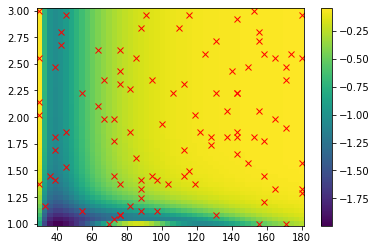

In [4]:
plt.pcolormesh(agrid, rgrid, egrid, shading='auto')
plt.plot(asample, rsample, 'rx')
plt.colorbar()

## Dataset from numpy arrays

In [5]:
from pinn.io import sparse_batch, load_numpy
data = {k:np.array(v) for k,v in data.items()}
dataset = lambda: load_numpy(data, splits={'train':8, 'test':2})

train = lambda: dataset()['train'].shuffle(100).repeat().apply(sparse_batch(100))
test = lambda: dataset()['test'].repeat().apply(sparse_batch(100))

## Training

### Model specification

In [7]:
import pinn

params={
    'model_dir': '/Users/miguelnavaharris/Project/PiNN_LJ_original',
    'network': {
        'name': 'PiNet',
        'params': {
            'ii_nodes':[8,8],
            'pi_nodes':[8,8],
            'pp_nodes':[8,8],
            'out_nodes':[8,8],
            'depth': 4,
            'rc': 3.0,
            'atom_types':[1]}},
    'model':{
        'name': 'potential_model',
        'params': {
            'e_dress': {1:-0.3},  # element-specific energy dress
            'e_scale': 2, # energy scale for prediction
            'e_unit': 1.0,  # output unit of energy dur
            'log_e_per_atom': True, # log e_per_atom and its distribution    
            'use_force': True}}}      # include force in Loss function
model = pinn.get_model(params)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/Users/miguelnavaharris/Project/PiNN_LJ_original', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [8]:
%rm -rf /tmp/PiNet
train_spec = tf.estimator.TrainSpec(input_fn=train, max_steps=5e3)
eval_spec = tf.estimator.EvalSpec(input_fn=test, steps=10)
tf.estimator.train_and_evaluate(model, train_spec, eval_spec)

INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead
INFO:tensorflow:Calling model_fn.
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
3144 trainable vaiabless, training with float32 precision.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
Metal device set to: Apple M1

systemMemor

2023-03-30 13:41:37.703694: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-30 13:41:37.703800: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-03-30 13:41:37.753259: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-30 13:41:37.754552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-03-30 13:41:37.996998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-03-30 13:41:38.042060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-03-30 13:41:38.054987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-03-30 13:41:38.104861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /Users/miguelnavaharris/Project/PiNN_LJ_original/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


2023-03-30 13:41:38.835733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-03-30 13:41:39.024271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-03-30 13:41:39.039763: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-03-30 13:41:39.047349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-03-30 13:41:39.520795: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-30 13:41:39.520819: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:lo

INFO:tensorflow:loss = 23.887947, step = 0


2023-03-30 13:41:40.691361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument: Incompatible shapes: [300,8] vs. [299,8]
	 [[node METRICS/gradients/pi_net/res_update/add_grad/BroadcastGradientArgs (defined at Users/miguelnavaharris/PiNN/pinn/models/potential.py:165) ]]
  (1) Invalid argument: Incompatible shapes: [300,8] vs. [299,8]
	 [[node METRICS/gradients/pi_net/res_update/add_grad/BroadcastGradientArgs (defined at Users/miguelnavaharris/PiNN/pinn/models/potential.py:165) ]]
	 [[pi_net/gc_block_1/pi_layer_1/GatherV2_1/_1813]]
0 successful operations.
0 derived errors ignored.

Original stack trace for 'METRICS/gradients/pi_net/res_update/add_grad/BroadcastGradientArgs':
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
    self.io_loop.start()
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
    self._run_once()
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
    handle._run()
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 473, in dispatch_queue
    await self.process_one()
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 462, in process_one
    await dispatch(*args)
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 369, in dispatch_shell
    await result
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 664, in execute_request
    reply_content = await reply_content
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 355, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
    return super().run_cell(*args, **kwargs)
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2854, in run_cell
    result = self._run_cell(
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2900, in _run_cell
    return runner(coro)
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3098, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3301, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3361, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "var/folders/2r/53clw21s5zv7ml4w3_xhd8v40000gq/T/ipykernel_31909/1643968620.py", line 4, in <cell line: 4>
    tf.estimator.train_and_evaluate(model, train_spec, eval_spec)
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/tensorflow_estimator/python/estimator/training.py", line 505, in train_and_evaluate
    return executor.run()
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/tensorflow_estimator/python/estimator/training.py", line 646, in run
    return self.run_local()
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/tensorflow_estimator/python/estimator/training.py", line 743, in run_local
    self._estimator.train(
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 349, in train
    loss = self._train_model(input_fn, hooks, saving_listeners)
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1175, in _train_model
    return self._train_model_default(input_fn, hooks, saving_listeners)
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1203, in _train_model_default
    estimator_spec = self._call_model_fn(features, labels, ModeKeys.TRAIN,
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1163, in _call_model_fn
    model_fn_results = self._model_fn(features=features, **kwargs)
  File "Users/miguelnavaharris/PiNN/pinn/models/potential.py", line 65, in potential_model
    metrics = make_metrics(features, pred, model_params, mode)
  File "Users/miguelnavaharris/PiNN/pinn/utils.py", line 137, in named_layer
    return func(*args, **kwargs)
  File "Users/miguelnavaharris/PiNN/pinn/models/potential.py", line 116, in make_metrics
    f_pred = -_get_dense_grad(pred, features['coord'])
  File "Users/miguelnavaharris/PiNN/pinn/models/potential.py", line 165, in _get_dense_grad
    grad = tf.gradients(energy, coord)[0]
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/tensorflow/python/ops/gradients_impl.py", line 315, in gradients_v2
    return gradients_util._GradientsHelper(
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/tensorflow/python/ops/gradients_util.py", line 681, in _GradientsHelper
    in_grads = _MaybeCompile(grad_scope, op, func_call,
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/tensorflow/python/ops/gradients_util.py", line 338, in _MaybeCompile
    return grad_fn()  # Exit early
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/tensorflow/python/ops/gradients_util.py", line 682, in <lambda>
    lambda: grad_fn(op, *out_grads))
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/tensorflow/python/ops/math_grad.py", line 1298, in _AddGrad
    SmartBroadcastGradientArgs(x, y, grad))
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/tensorflow/python/ops/math_grad.py", line 109, in SmartBroadcastGradientArgs
    rx, ry = gen_array_ops.broadcast_gradient_args(sx, sy)
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/tensorflow/python/ops/gen_array_ops.py", line 749, in broadcast_gradient_args
    _, _, _op, _outputs = _op_def_library._apply_op_helper(
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/tensorflow/python/framework/op_def_library.py", line 748, in _apply_op_helper
    op = g._create_op_internal(op_type_name, inputs, dtypes=None,
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/tensorflow/python/framework/ops.py", line 3557, in _create_op_internal
    ret = Operation(
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/tensorflow/python/framework/ops.py", line 2045, in __init__
    self._traceback = tf_stack.extract_stack_for_node(self._c_op)

...which was originally created as op 'pi_net/res_update/add', defined at:
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
[elided 27 identical lines from previous traceback]
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1163, in _call_model_fn
    model_fn_results = self._model_fn(features=features, **kwargs)
  File "Users/miguelnavaharris/PiNN/pinn/models/potential.py", line 58, in potential_model
    pred = network(features)
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py", line 783, in __call__
    outputs = call_fn(cast_inputs, *args, **kwargs)
  File "Users/miguelnavaharris/PiNN/pinn/networks/pinet.py", line 196, in call
    for i in range(self.depth):
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/tensorflow/python/autograph/operators/control_flow.py", line 443, in for_stmt
    _py_for_stmt(iter_, extra_test, body, None, None)
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/tensorflow/python/autograph/operators/control_flow.py", line 472, in _py_for_stmt
    body(target)
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/tensorflow/python/autograph/operators/control_flow.py", line 458, in protected_body
    original_body(protected_iter)
  File "Users/miguelnavaharris/PiNN/pinn/networks/pinet.py", line 199, in call
    tensors['prop'] = self.res_update[i]([tensors['prop'], prop])
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py", line 783, in __call__
    outputs = call_fn(cast_inputs, *args, **kwargs)
  File "Users/miguelnavaharris/PiNN/pinn/networks/pinet.py", line 128, in call
    return self.transform(old) + new
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py", line 1234, in binary_op_wrapper
    return func(x, y, name=name)
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py", line 206, in wrapper
    return target(*args, **kwargs)
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py", line 1565, in _add_dispatch
    return gen_math_ops.add_v2(x, y, name=name)
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/tensorflow/python/ops/gen_math_ops.py", line 532, in add_v2
    _, _, _op, _outputs = _op_def_library._apply_op_helper(
  File "Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/tensorflow/python/framework/op_def_library.py", line 748, in _apply_op_helper
    op = g._create_op_internal(op_type_name, inputs, dtypes=None,


## Validate the results
### PES analysis

In [ ]:
atoms = Atoms('H3', calculator=pinn.get_calc(model))
epred = np.zeros([na, nr])
for i in range(na):
    for j in range(nr):
        a, r = arange[i], rrange[j]
        atoms = three_body_sample(atoms, a, r)
        epred[i,j] = atoms.get_potential_energy()

In [ ]:
plt.pcolormesh(agrid, rgrid, epred, shading='auto')
plt.colorbar()
plt.title('NN predicted PES')
plt.figure()
plt.pcolormesh(agrid, rgrid, np.abs(egrid-epred), shading='auto')
plt.plot(asample, rsample, 'rx')
plt.title('NN Prediction error and sampled points')
plt.colorbar()

### Pairwise potential analysis

In [ ]:
atoms1 = Atoms('H2', calculator=pinn.get_calc(model))
atoms2 = Atoms('H2', calculator=LennardJones())

nr2 = 100
rrange2 = np.linspace(1,1.9,nr2)
epred = np.zeros(nr2)
etrue = np.zeros(nr2)

for i in range(nr2):
    pos = [[0, 0, 0],
           [rrange2[i], 0, 0]]
    atoms1.set_positions(pos)
    atoms2.set_positions(pos)
    epred[i] = atoms1.get_potential_energy()
    etrue[i] = atoms2.get_potential_energy()

In [ ]:
f, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
ax1.plot(rrange2, epred)
ax1.plot(rrange2, etrue,'--')
ax1.legend(['Prediction', 'Truth'], loc=4)
_=ax2.hist(np.concatenate(distsample,0), 20, range=(1,1.9))

## Molecular dynamics with ASE

In [ ]:
from ase import units
from ase.io import Trajectory
from ase.md.nvtberendsen import NVTBerendsen
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution

In [ ]:
atoms = Atoms('H', cell=[2, 2, 2], pbc=True)
atoms = atoms.repeat([5,5,5])
atoms.rattle()
atoms.set_calculator(pinn.get_calc(model))
MaxwellBoltzmannDistribution(atoms, 300*units.kB)
dyn = NVTBerendsen(atoms, 0.5 * units.fs, 300, taut=0.5*100*units.fs)
dyn.attach(Trajectory('ase_nvt.traj', 'w', atoms).write, interval=10)
dyn.run(5000)